In [1]:
from Annotation_helper import *
import numpy as np
from collections import defaultdict
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tempfile
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
import missingno as msno

In [3]:
import seaborn as sns
sns.set()

SMALL_SIZE = 15
MEDIUM_SIZE = 17
BIGGER_SIZE = 19

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
data_folder = "../../Data"
structured_data_folder = data_folder + "/structured_data"
text_path = data_folder + "/text"
data_path = structured_data_folder + "/test.csv"
dist_folder = structured_data_folder + "/filtered_Distances"
figure_folder = "../Figures/Results/Embeddings"
model_folder = "../Models/Embeddings"
matches = pd.read_csv(structured_data_folder + "/Matches/Bas3.csv", index_col=0)
figure_folder = "../Figures/EDA/"

In [5]:
transactions = load_transactions("../../Data/structured_data\VOC Cochin Slave Transactions 1706-1801 - IISH - Database - 2018 - v1.csv")
permissions = load_permissions("../../Data/structured_data\VOC Cochin Slave Transport Permissions 1770-1795 - IISH - Database - 2018 - v1.csv")

In [6]:
transactions

,Unnamed: 0,ID,Datum,VerkoperVoornaam,VerkoperPatroniem,VerkoperTussen,VerkoperAchternaam,VerkoperGender,VerkoperHerkomst,VerkoperBeroep,...,KoperEtniciteit,KoperStatus,SlaafNaamNieuw,SlaafNaamOrigineel,SlaafTaalNaam,SlaafKaste,SlaafGender,SlaafLeeftijd,Opmerking,Entry-ID
0,0,554-1-1,1753-01-02,Michiel,NaN,NaN,Kruijs,m,NaN,Metselaar,...,NaN,VOC,December,NaN,NaN,NaN,m,NaN,NaN,0
1,1,554-3-1,1753-01-02,Michiel,NaN,NaN,Kruijs,m,NaN,Metselaar,...,NaN,VOC,Neptunes,NaN,NaN,NaN,m,NaN,NaN,1
2,2,554-5-1,1753-01-11,Gillis,NaN,van der,Sloot,m,NaN,Assistent,...,NaN,VOC,Dalima,NaN,NaN,NaN,v,NaN,NaN,2
3,3,554-6-1,1753-01-12,Michiel,NaN,NaN,Kruys,m,NaN,Metselaar,...,NaN,VOC,Februarij,NaN,NaN,NaN,m,NaN,NaN,3
4,4,554-8-1,1753-01-13,Jacob,NaN,NaN,Smit,m,NaN,Serg[eant],...,NaN,VOC,Fortuyn,NaN,NaN,NaN,m,NaN,"[datum deels onleesbaar, waarschijnlijk 1753; ...",4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7192,7192,1434-146-1,1793-12-09,Schoesen,NaN,NaN,Mira,o,NaN,NaN,...,Moor,Woonagtig te Kalwettij,Tanjon,Kadia,NaN,Moor,v,15,NaN,7192
7193,7193,1434-147-1,1793-12-09,Marielwittil Schoe,NaN,NaN,Miran,o,NaN,NaN,...,Moor,Woonagtig te Kalwettij,Ambar,Koroenba,Mallabaars,Parea Heiden,m,16,NaN,7193
7194,7194,1434-148-1,1793-12-09,Seidoe,NaN,NaN,Japhar,m,NaN,NaN,...,Moor,Woonagtig te Kalwettij,August,Tjatten,Mallabaars,Poelia Heiden,m,16,NaN,7194
7195,7195,1434-149-1,1793-12-09,Madatilparambil Tjangaren,NaN,NaN,Koma,o,NaN,NaN,...,Moor,Woonagtig te Kalwettij,September,Ramen,Mallabaars,Bettua Heiden,m,13,NaN,7195


In [7]:
transactions["Verkopernaam"] = transactions["VerkoperVoornaam"].fillna("") + " " + transactions["VerkoperTussen"].fillna("") + " " + transactions["VerkoperAchternaam"].fillna("")
transactions["Kopernaam"] = transactions["KoperVoornaam"].fillna("") + " " + transactions["KoperTussen"].fillna("") + " " + transactions["KoperAchternaam"].fillna("")
permissions["Bezitternaam"] = permissions["BezitterVoornaam"].fillna("") + " " + permissions["BezitterTussen"].fillna("") + " " + permissions["BezitterAchternaam"].fillna("")

In [8]:
print("Number of unique sellers: ", len(transactions["Verkopernaam"].unique()))
print("Number of unique buyers: ", len(transactions["Kopernaam"].unique()))
print("Number of unique owners: ", len(permissions["Bezitternaam"].unique()))

Number of unique sellers:  4700
Number of unique buyers:  3406
Number of unique owners:  1238


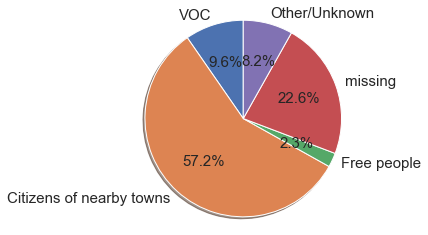

In [9]:
n_total = transactions.shape[0]
n_voc_sellers = (transactions["VerkoperStatus"] == "VOC").sum()
n_inw_sellers = transactions["VerkoperStatus"].str.contains('inw', case=False, regex=True).sum()
n_free_sellers = transactions["VerkoperStatus"].str.contains('vrij', case=False, regex=True).sum()
n_missing_buyers = transactions["KoperStatus"].isna().sum()


labels = 'VOC', 'Citizens of nearby towns', 'Free people', 'missing', 'Other/Unknown'
sizes = [n_voc_sellers, n_inw_sellers, n_free_sellers, n_missing_buyers]
sizes.append(n_total - sum(sizes))

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig(figure_folder + 'seller_status.png', bbox_inches='tight')

[3457, 367, 935, 1626, 803]


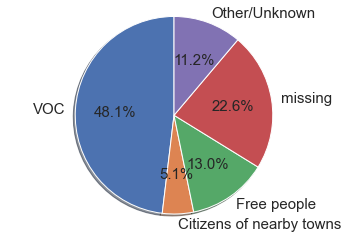

In [10]:
n_total = transactions.shape[0]
n_voc_sellers = (transactions["KoperStatus"] == "VOC").sum()
n_inw_sellers = transactions["KoperStatus"].str.contains('inw', case=False, regex=True).sum()
n_free_sellers = transactions["KoperStatus"].str.contains('vrij', case=False, regex=True).sum()
n_missing_buyers = transactions["KoperStatus"].isna().sum()


labels = 'VOC', 'Citizens of nearby towns', 'Free people', 'missing', 'Other/Unknown'
sizes = [n_voc_sellers, n_inw_sellers, n_free_sellers, n_missing_buyers]
sizes.append(n_total - sum(sizes))
print(sizes)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig(figure_folder + 'buyer_status.png', bbox_inches='tight')

In [11]:
transactions["KoperStatus"].isna().sum()

1626

[568, 10, 167, 2991, 102]


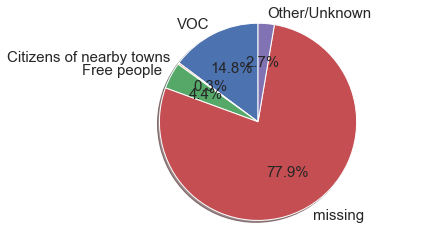

In [12]:
n_total = permissions.shape[0]
n_voc_sellers = (permissions["BezitterStatus"] == "VOC").sum()
n_inw_sellers = permissions["BezitterStatus"].str.contains('inw', case=False, regex=True).sum()
n_free_sellers = permissions["BezitterStatus"].str.contains('vrij', case=False, regex=True).sum()
n_missing_buyers = permissions["BezitterStatus"].isna().sum()


labels = 'VOC', 'Citizens of nearby towns', 'Free people', 'missing', 'Other/Unknown'
sizes = [n_voc_sellers, n_inw_sellers, n_free_sellers, n_missing_buyers]
sizes.append(n_total - sum(sizes))
print(sizes)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig(figure_folder + 'owner_status.png', bbox_inches='tight')

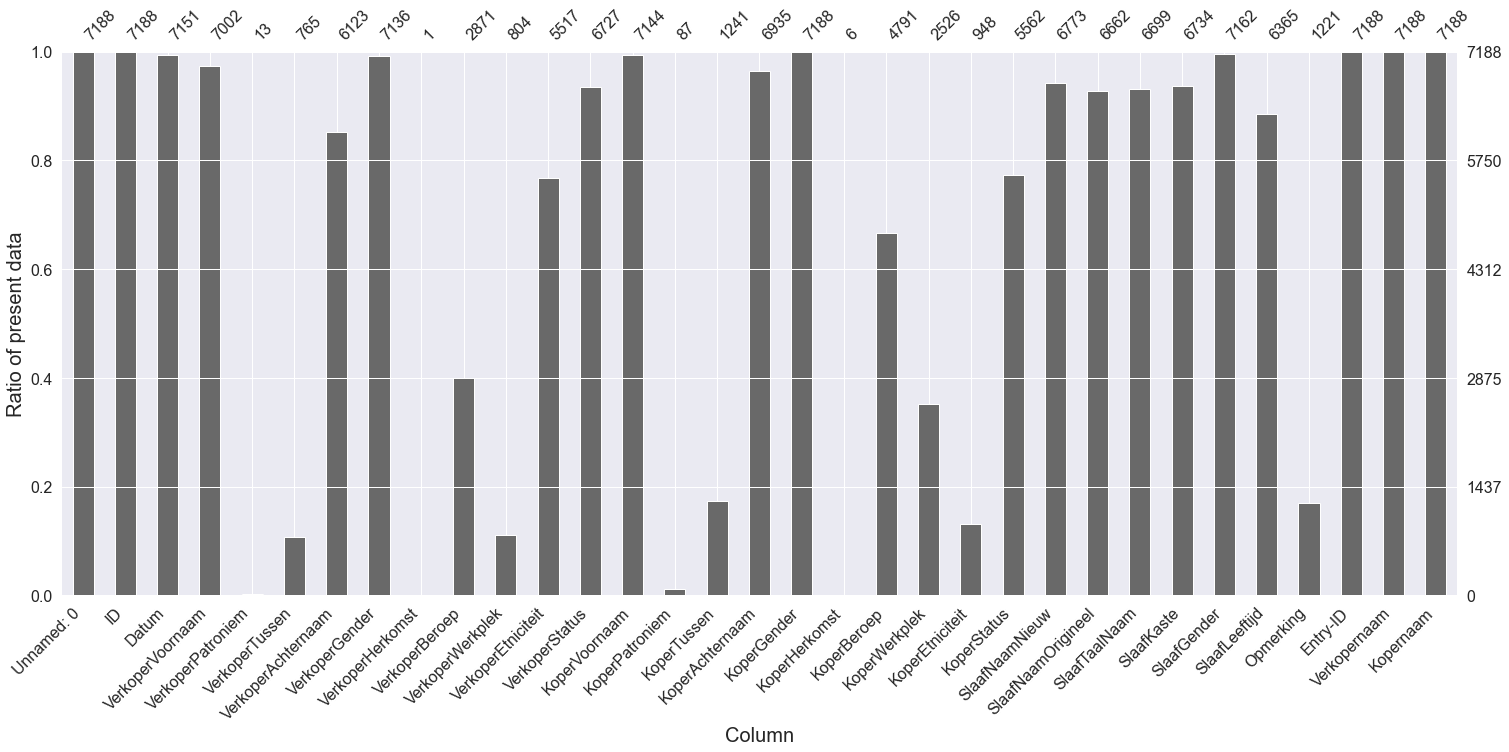

In [13]:
fontsize = 20
ax = msno.bar(transactions)
ax.set_xlabel('Column', fontsize=fontsize)
ax.set_ylabel('Ratio of present data', fontsize=fontsize)

plt.savefig(figure_folder + 'missing_transaction.png', bbox_inches='tight')

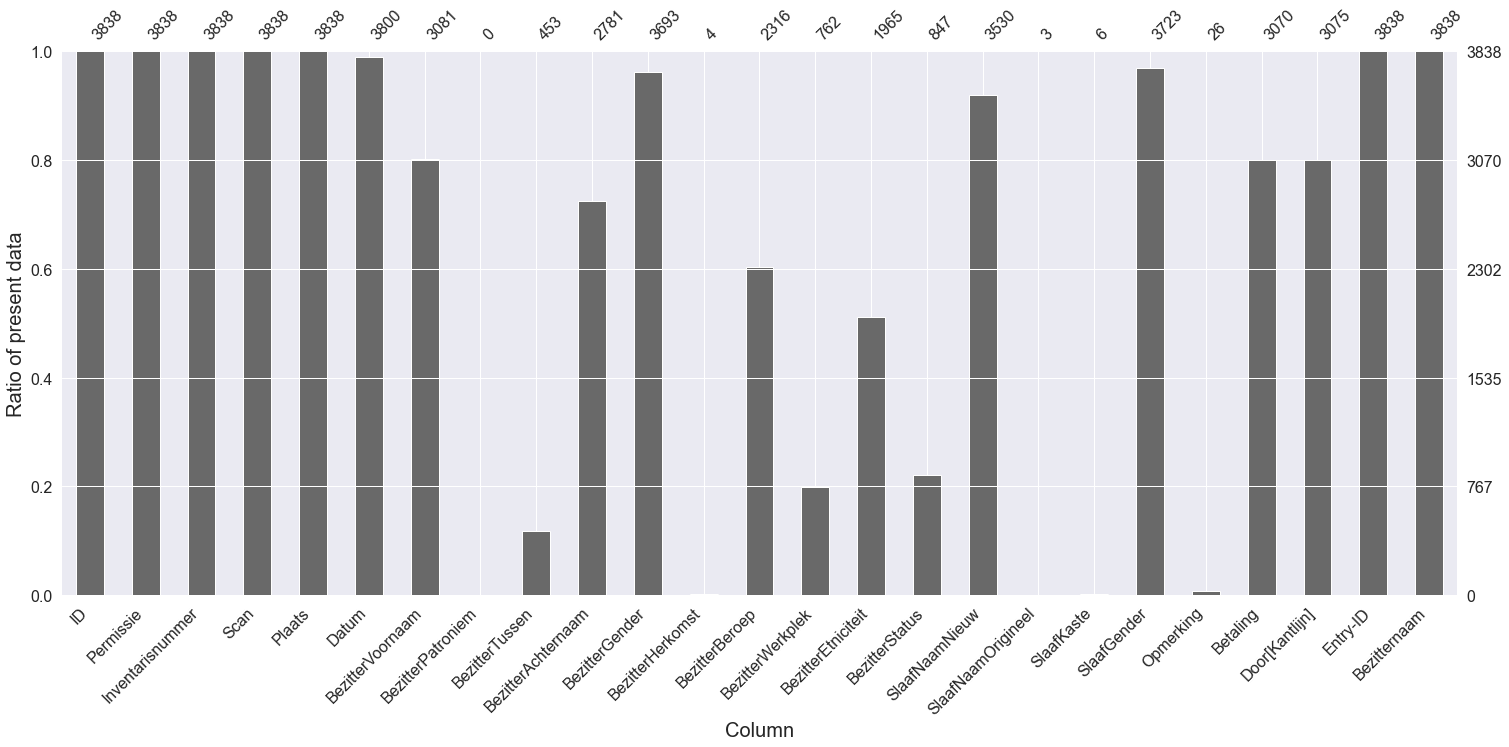

In [14]:
fontsize = 20
ax = msno.bar(permissions)
ax.set_xlabel('Column', fontsize=fontsize)
ax.set_ylabel('Ratio of present data', fontsize=fontsize)

plt.savefig(figure_folder + 'missing_permission.png', bbox_inches='tight')

# Distances EDA

In [15]:
distances = pd.read_csv(dist_folder + "/distances_0.csv", dtype={'permission_indx': 'uint16', 'transaction_indx': 'uint16', 'SlaafGender': 'bool', 'SlaafNaamNieuw': 'float16', 'BezitterGender': 'bool', 'BezitterVoornaam': 'float16', 'BezitterBeroep': 'float16', 'BezitterAchternaam': 'float16'})
for i in range(1, 99):
    df2 = pd.read_csv(f"{dist_folder}/distances_{i}.csv", dtype={'permission_indx': 'uint16', 'transaction_indx': 'uint16', 'SlaafGender': 'bool', 'SlaafNaamNieuw': 'float16', 'BezitterGender': 'bool', 'BezitterVoornaam': 'float16', 'BezitterBeroep': 'float16', 'BezitterAchternaam': 'float16'})
    distances = pd.concat([distances, df2])
distances.reset_index(inplace=True)

In [16]:
distances["Match"] = 0
for i, match in matches.iterrows():
    if match["transaction_indx"] != "None":
        indx = distances.query(f"permission_indx == {match['permission_indx']} & transaction_indx == {match['transaction_indx']}").index
        distances.loc[indx, "Match"] = 1

In [17]:
only_matches = distances[distances["Match"] == 1]
no_matches = distances[distances["Match"] == 0]

In [18]:
set(list(distances["Match"]))

{0, 1}

In [19]:
distances

,index,permission_indx,transaction_indx,SlaafGender,SlaafNaamNieuw,BezitterGender,BezitterVoornaam,BezitterTussen,BezitterAchternaam,BezitterBeroep,BezitterStatus,BezitterEtniciteit,Match
0,0,0,0,True,0.000000,False,0.000000,0.0,0.000000,0.0,0.0,0.0,0
1,1,0,1,True,0.250000,False,0.000000,0.0,0.000000,0.0,0.0,0.0,0
2,2,0,2,False,0.166626,False,0.000000,0.0,0.000000,0.0,0.0,0.0,0
3,3,0,3,True,0.111084,False,0.000000,0.0,0.000000,0.0,0.0,0.0,0
4,4,0,4,True,0.142822,False,0.000000,0.0,0.000000,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26638723,265951,3889,7192,True,0.250000,True,0.166626,0.0,0.166626,0.0,0.0,1.0,0
26638724,265952,3889,7193,False,0.250000,True,0.166626,0.0,0.166626,0.0,0.0,1.0,0
26638725,265953,3889,7194,False,0.000000,True,0.277832,0.0,0.000000,0.0,0.0,1.0,0
26638726,265954,3889,7195,False,0.000000,True,0.166626,0.0,0.166626,0.0,0.0,1.0,0


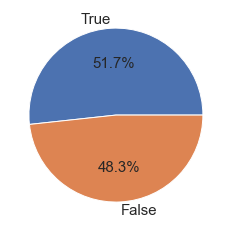

In [20]:
def boolean_pie_chart(ax, col, col_name=None, y_label=None):
    true = (col == 1).sum()
    false = (col == 0).sum()
    ax.pie([true, false], labels=["True", "False"], autopct='%1.1f%%')
    
boolean_pie_chart(plt, distances["SlaafGender"])

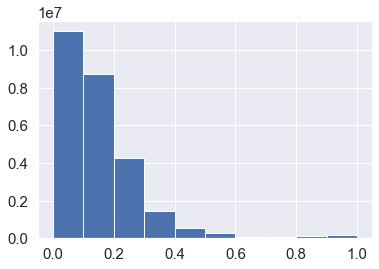

In [21]:
def hist_plot(ax, col, col_name=None, y_label=False):
    ax.hist(col)
    if col_name:
        ax.set_xlabel(col_name)
    if y_label:
        ax.set_ylabel("Number of occurences")

hist_plot(plt, distances["SlaafNaamNieuw"])

In [22]:
def plot_datasets(dfs, plt_func, col_name=""):
    fig, axs = plt.subplots(1, len(dfs), figsize=(10,3))
    for j, df in enumerate(dfs):
        if j == 0:
            y_label = 1
        else:
            y_label = 0
        plt_func[0](axs[j], df[0][plt_func[1]], col_name=col_name, y_label=y_label)
        axs[j].set_title(df[1])
    plt.tight_layout()
    plt.savefig(figure_folder + f"distribution_{col_name}.png")
    plt.show()

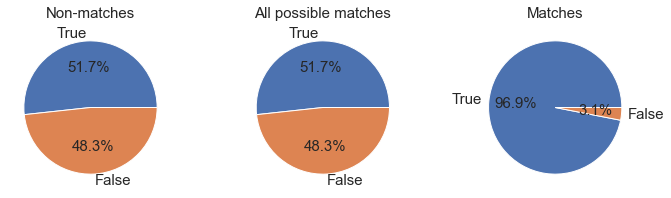

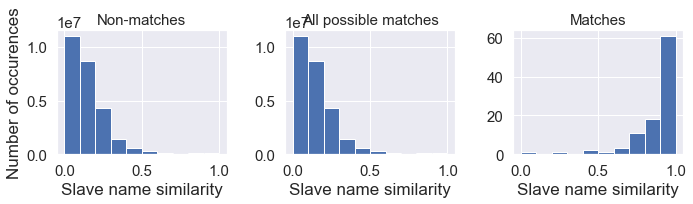

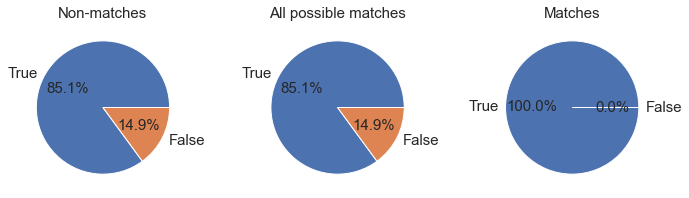

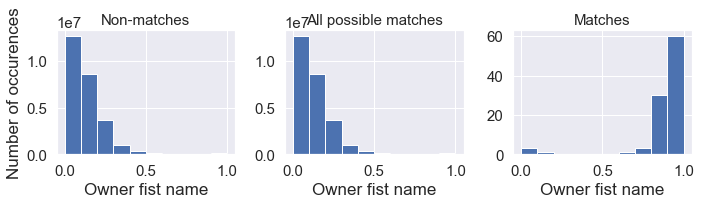

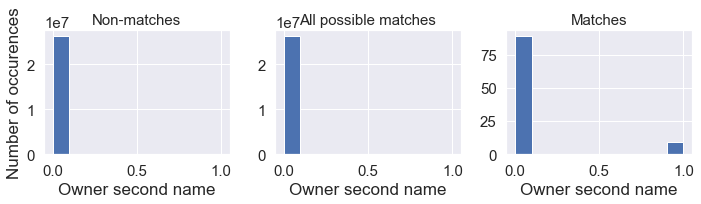

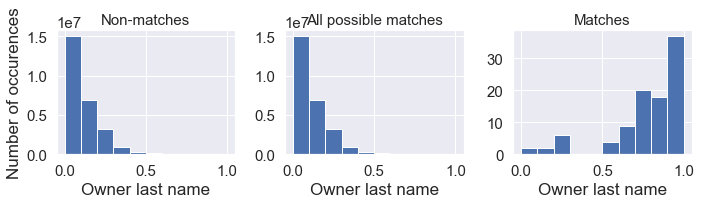

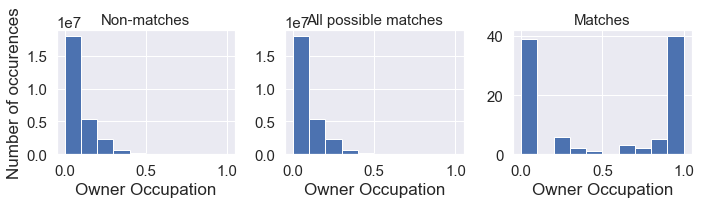

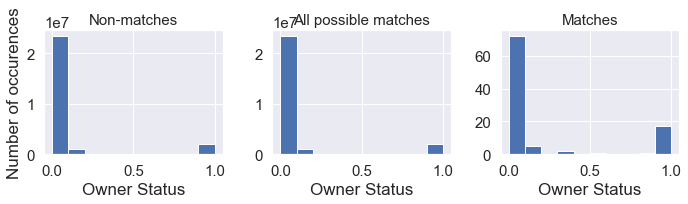

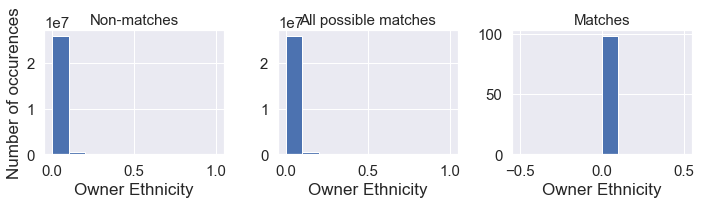

In [23]:
plot_datasets([(no_matches, "Non-matches"), (distances, "All possible matches"), (only_matches, "Matches")], (boolean_pie_chart, "SlaafGender"), col_name="Slave Gender")
plot_datasets([(no_matches, "Non-matches"), (distances, "All possible matches"), (only_matches, "Matches")], (hist_plot, "SlaafNaamNieuw"), col_name="Slave name similarity")
plot_datasets([(no_matches, "Non-matches"), (distances, "All possible matches"), (only_matches, "Matches")], (boolean_pie_chart, "BezitterGender"), col_name="Owner Gender")
plot_datasets([(no_matches, "Non-matches"), (distances, "All possible matches"), (only_matches, "Matches")], (hist_plot, "BezitterVoornaam"), col_name="Owner fist name")
plot_datasets([(no_matches, "Non-matches"), (distances, "All possible matches"), (only_matches, "Matches")], (hist_plot, "BezitterTussen"), col_name="Owner second name")
plot_datasets([(no_matches, "Non-matches"), (distances, "All possible matches"), (only_matches, "Matches")], (hist_plot, "BezitterAchternaam"), col_name="Owner last name")
plot_datasets([(no_matches, "Non-matches"), (distances, "All possible matches"), (only_matches, "Matches")], (hist_plot, "BezitterBeroep"), col_name="Owner Occupation")
plot_datasets([(no_matches, "Non-matches"), (distances, "All possible matches"), (only_matches, "Matches")], (hist_plot, "BezitterStatus"), col_name="Owner Status")
plot_datasets([(no_matches, "Non-matches"), (distances, "All possible matches"), (only_matches, "Matches")], (hist_plot, "BezitterEtniciteit"), col_name="Owner Ethnicity")

In [24]:
only_matches

,index,permission_indx,transaction_indx,SlaafGender,SlaafNaamNieuw,BezitterGender,BezitterVoornaam,BezitterTussen,BezitterAchternaam,BezitterBeroep,BezitterStatus,BezitterEtniciteit,Match
226923,226923,32,4097,True,0.856934,True,0.769043,0.0,1.000000,0.884766,0.0,0.0,1
234255,234255,33,4242,True,1.000000,True,0.916504,0.0,1.000000,0.884766,0.0,0.0,1
241429,241429,34,4228,True,0.428467,True,0.846191,0.0,1.000000,0.307617,0.0,0.0,1
270173,270173,38,4220,True,0.777832,True,0.888672,0.0,0.714355,1.000000,0.0,0.0,1
284531,11387,40,4202,True,1.000000,True,1.000000,0.0,0.856934,1.000000,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3800735,249863,529,5475,True,0.777832,True,0.875000,0.0,0.625000,0.000000,1.0,0.0,1
3801093,250221,529,5833,True,0.888672,True,0.875000,0.0,0.625000,0.000000,1.0,0.0,1
3801201,250329,529,5941,True,0.888672,True,1.000000,0.0,0.625000,0.000000,1.0,0.0,1
3806706,255834,530,4257,True,1.000000,True,0.909180,0.0,1.000000,0.000000,0.0,0.0,1


In [25]:
no_matches

,index,permission_indx,transaction_indx,SlaafGender,SlaafNaamNieuw,BezitterGender,BezitterVoornaam,BezitterTussen,BezitterAchternaam,BezitterBeroep,BezitterStatus,BezitterEtniciteit,Match
0,0,0,0,True,0.000000,False,0.000000,0.0,0.000000,0.0,0.0,0.0,0
1,1,0,1,True,0.250000,False,0.000000,0.0,0.000000,0.0,0.0,0.0,0
2,2,0,2,False,0.166626,False,0.000000,0.0,0.000000,0.0,0.0,0.0,0
3,3,0,3,True,0.111084,False,0.000000,0.0,0.000000,0.0,0.0,0.0,0
4,4,0,4,True,0.142822,False,0.000000,0.0,0.000000,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26638723,265951,3889,7192,True,0.250000,True,0.166626,0.0,0.166626,0.0,0.0,1.0,0
26638724,265952,3889,7193,False,0.250000,True,0.166626,0.0,0.166626,0.0,0.0,1.0,0
26638725,265953,3889,7194,False,0.000000,True,0.277832,0.0,0.000000,0.0,0.0,1.0,0
26638726,265954,3889,7195,False,0.000000,True,0.166626,0.0,0.166626,0.0,0.0,1.0,0


In [26]:
only_matches.astype(float).mean()

index                 151946.612245
permission_indx          263.540816
transaction_indx        4008.642857
SlaafGender                0.969388
SlaafNaamNieuw             0.902149
BezitterGender             1.000000
BezitterVoornaam           0.907929
BezitterTussen             0.091837
BezitterAchternaam         0.776537
BezitterBeroep             0.510204
BezitterStatus             0.204514
BezitterEtniciteit         0.000000
Match                      1.000000
dtype: float64

In [27]:
no_matches.astype(float).mean()

index                 134562.054501
permission_indx         1891.308471
transaction_indx        3595.913479
SlaafGender                0.517150
SlaafNaamNieuw             0.126812
BezitterGender             0.850731
BezitterVoornaam           0.112158
BezitterTussen             0.008523
BezitterAchternaam         0.086993
BezitterBeroep             0.067127
BezitterStatus             0.084455
BezitterEtniciteit         0.007181
Match                      0.000000
dtype: float64

In [28]:
mean_only_matches = only_matches.astype(float).mean()[3:-1]
no_only_matches = no_matches.astype(float).mean()[3:-1]

In [29]:
pd.concat([mean_only_matches, no_only_matches], axis=1)

,0,1
SlaafGender,0.969388,0.517150
SlaafNaamNieuw,0.902149,0.126812
BezitterGender,1.000000,0.850731
BezitterVoornaam,0.907929,0.112158
BezitterTussen,0.091837,0.008523
BezitterAchternaam,0.776537,0.086993
BezitterBeroep,0.510204,0.067127
BezitterStatus,0.204514,0.084455
BezitterEtniciteit,0.000000,0.007181


In [30]:
no_only_matches.index

Index(['SlaafGender', 'SlaafNaamNieuw', 'BezitterGender', 'BezitterVoornaam',
       'BezitterTussen', 'BezitterAchternaam', 'BezitterBeroep',
       'BezitterStatus', 'BezitterEtniciteit'],
      dtype='object')

In [31]:
index = ["Slave Gender Similarity", "Slave Name Similarity", "Owner Gender Similarity", "Owner First Name Similarity", "Owner Second Name Similarity", "Owner Last Name Similarity", "Owner Occupation Similarity", "Owner Status Similarity", "Owner Ethnicity Similarity"]
mean = pd.concat([mean_only_matches, (mean_only_matches - no_only_matches).abs(), no_only_matches], axis=1)
mean.index = index
mean.columns = ["Matches", "Difference", "No Matches"]
print(mean.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &   Matches &  Difference &  No Matches \\
\midrule
Slave Gender Similarity      &  0.969388 &    0.452238 &    0.517150 \\
Slave Name Similarity        &  0.902149 &    0.775338 &    0.126812 \\
Owner Gender Similarity      &  1.000000 &    0.149269 &    0.850731 \\
Owner First Name Similarity  &  0.907929 &    0.795771 &    0.112158 \\
Owner Second Name Similarity &  0.091837 &    0.083313 &    0.008523 \\
Owner Last Name Similarity   &  0.776537 &    0.689544 &    0.086993 \\
Owner Occupation Similarity  &  0.510204 &    0.443077 &    0.067127 \\
Owner Status Similarity      &  0.204514 &    0.120059 &    0.084455 \\
Owner Ethnicity Similarity   &  0.000000 &    0.007181 &    0.007181 \\
\bottomrule
\end{tabular}



In [32]:
permissions

,ID,Permissie,Inventarisnummer,Scan,Plaats,Datum,BezitterVoornaam,BezitterPatroniem,BezitterTussen,BezitterAchternaam,...,BezitterStatus,SlaafNaamNieuw,SlaafNaamOrigineel,SlaafKaste,SlaafGender,Opmerking,Betaling,Door[Kantlijn],Entry-ID,Bezitternaam
0,897-1-1,1,897,1,Cochin,1770-08-06,NaN,NaN,NaN,NaN,...,NaN,Tutius,NaN,NaN,m,NaN,Mits betalende geregtigheijd aan den pagter en...,NaN,0,
1,897-1-2,2,897,1,Cochin,1770-08-06,NaN,NaN,NaN,NaN,...,NaN,Cu[…],NaN,NaN,m,NaN,Mits betalende geregtigheijd aan den pagter en...,NaN,1,
2,897-1-3,3,897,1,Cochin,1770-08-06,NaN,NaN,NaN,NaN,...,NaN,Barido,NaN,NaN,m,NaN,Mits betalende geregtigheijd aan den pagter en...,NaN,2,
3,897-1-4,4,897,1,Cochin,1770-08-06,NaN,NaN,NaN,NaN,...,NaN,April,NaN,NaN,m,NaN,Mits betalende geregtigheijd aan den pagter en...,NaN,3,
4,897-1-5,5,897,1,Cochin,1770-08-06,NaN,NaN,NaN,NaN,...,NaN,Joan,NaN,NaN,m,NaN,Mits betalende geregtigheijd aan den pagter en...,NaN,4,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3922,1333-243-1,1,1333,243,Cochin,1795-05-01,Jean,NaN,NaN,Jasjean,...,NaN,Dalida,NaN,NaN,v,NaN,Gerechtigheid,NaN,3922,Jean Jasjean
3923,1333-243-2,2,1333,243,Cochin,1795-05-04,Douglas,NaN,NaN,NaN,...,NaN,Flo[...],NaN,NaN,NaN,NaN,Gerechtigheid,NaN,3923,Douglas
3924,1333-243-3,3,1333,243,Cochin,1795-05-04,Jakob,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,m,NaN,NaN,NaN,3924,Jakob
3926,1333-243-5,5,1333,243,Cochin,1795-[...]-[...],Domingo,NaN,de,Roza,...,NaN,Roza,NaN,NaN,v,NaN,NaN,NaN,3926,Domingo de Roza
